Kernel: Py39_cellrank

In [1]:
import glob
import scanpy as sc
import scvelo as scv
import pandas as pd
import numpy as np
#import igraph
import matplotlib as plt
import cellrank as cr
print(scv.__version__)
print(cr.__version__)

0.3.1
2.0.2


## Velocity analysis

### Import data

Metadata

In [19]:
meta_data = pd.read_csv('../seurat_harmony_n70551.csv', index_col=0)
print(meta_data.shape)
meta_data.head(1)

(70551, 23)


orig.ident  nCount_RNA  nFeature_RNA  \
AAACCCACAGGTGTTT-1_6289-MW-0031        ast        4564          2277   

                                   SampleName Unified_region  Donor.ID  \
AAACCCACAGGTGTTT-1_6289-MW-0031  6289-MW-0031             EC      2068   

                                 Path..Group. Ast_clust  percent.mt  samp_n  \
AAACCCACAGGTGTTT-1_6289-MW-0031             1    astIM1     0.35057     386   

                                 ...  Temporal_Geneset4_AvgScaledExprs  \
AAACCCACAGGTGTTT-1_6289-MW-0031  ...                          0.014288   

                                    UMAP1     UMAP2  clust_n  org.UMAP1  \
AAACCCACAGGTGTTT-1_6289-MW-0031 -1.140746  0.336926    31399  -0.336926   

                                 org.UMAP2  seurat_clusters_org  \
AAACCCACAGGTGTTT-1_6289-MW-0031  -1.140746                  c.0   

                                 seurat_clusters_renamed  \
AAACCCACAGGTGTTT-1_6289-MW-0031                   0_astH   

                                 ClusterNames_0.3_20PC Monocle_pseudotime  
AAACCCACAGGTGTTT-1_6289-MW-0031                 0_astH            6.15932  

[1 rows x 23 columns]

Unsplice/Splice data

In [3]:
ec = scv.read('./merged_velocyto_loom_EC.h5ad')
ba20 = scv.read('./merged_velocyto_loom_BA20.h5ad')
ba46 = scv.read('./merged_velocyto_loom_PFC.h5ad')
v2 = scv.read('./merged_velocyto_loom_V2.h5ad')
V1 = scv.read('./merged_velocyto_loom_V1.h5ad')

In [5]:
adata = sc.concat([ec, ba20, ba46, v2, V1], axis = 0, join = 'outer')

In [6]:
adata

AnnData object with n_obs × n_vars = 68924 × 62710
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

### Pre-processing and adding in our metadata from Seurat

In [20]:
# adding in UMAP metadata
umap_coord = meta_data.loc[adata.obs.index,:][['UMAP1','UMAP2']]
assert umap_coord.index.all() == adata.obs.index.all()
adata.obsm['X_umap'] = umap_coord.values

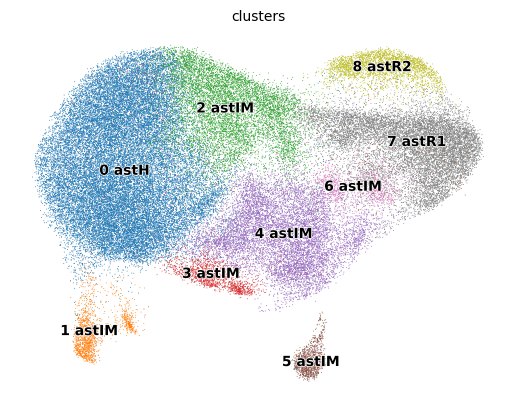

In [27]:
#adding in cluster metadata
labels = meta_data.loc[adata.obs.index,:]['seurat_clusters_renamed']
assert labels.index.all() == adata.obs.index.all()
adata.obs['clusters'] = labels.values

#check to make sure ablut labels and umap
scv.pl.umap(adata, color="clusters")

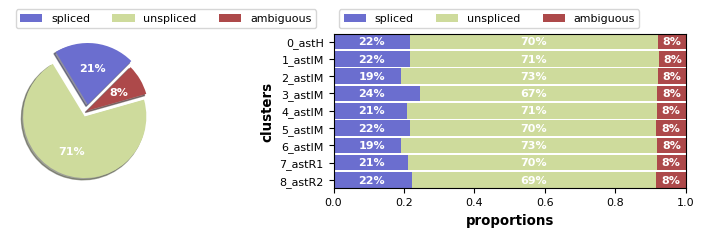

In [10]:
scv.pl.proportions(adata)

### Computing velocity with scVelo

Filter out genes which don’t have enough spliced/unspliced counts,   

In [11]:
#start running scv...
scv.pp.filter_and_normalize(
    adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=False
)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 50141 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/autofs/space/mindds_001/software/huanli/anaconda3/envs/cellrank/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


computing moments based on connectivities
    finished (0:00:55) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [12]:
#running scv in dynamics mode (not stochastic!)
scv.tl.recover_dynamics(adata, n_jobs = 24)
scv.tl.velocity(adata, mode="dynamical")
scv.tl.velocity_graph(adata)

recovering dynamics (using 24/104 cores)


  0%|          | 0/460 [00:00<?, ?gene/s]

    finished (0:06:20) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:35) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/104 cores)


  0%|          | 0/68924 [00:00<?, ?cells/s]

    finished (0:01:54) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [13]:
#get latent time
scv.tl.latent_time(adata)

computing terminal states
    identified 10 regions of root cells and 1 region of end points .
    finished (0:05:31) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:01:32) --> added 
    'latent_time', shared time (adata.obs)


/autofs/space/mindds_001/software/huanli/anaconda3/envs/cellrank/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


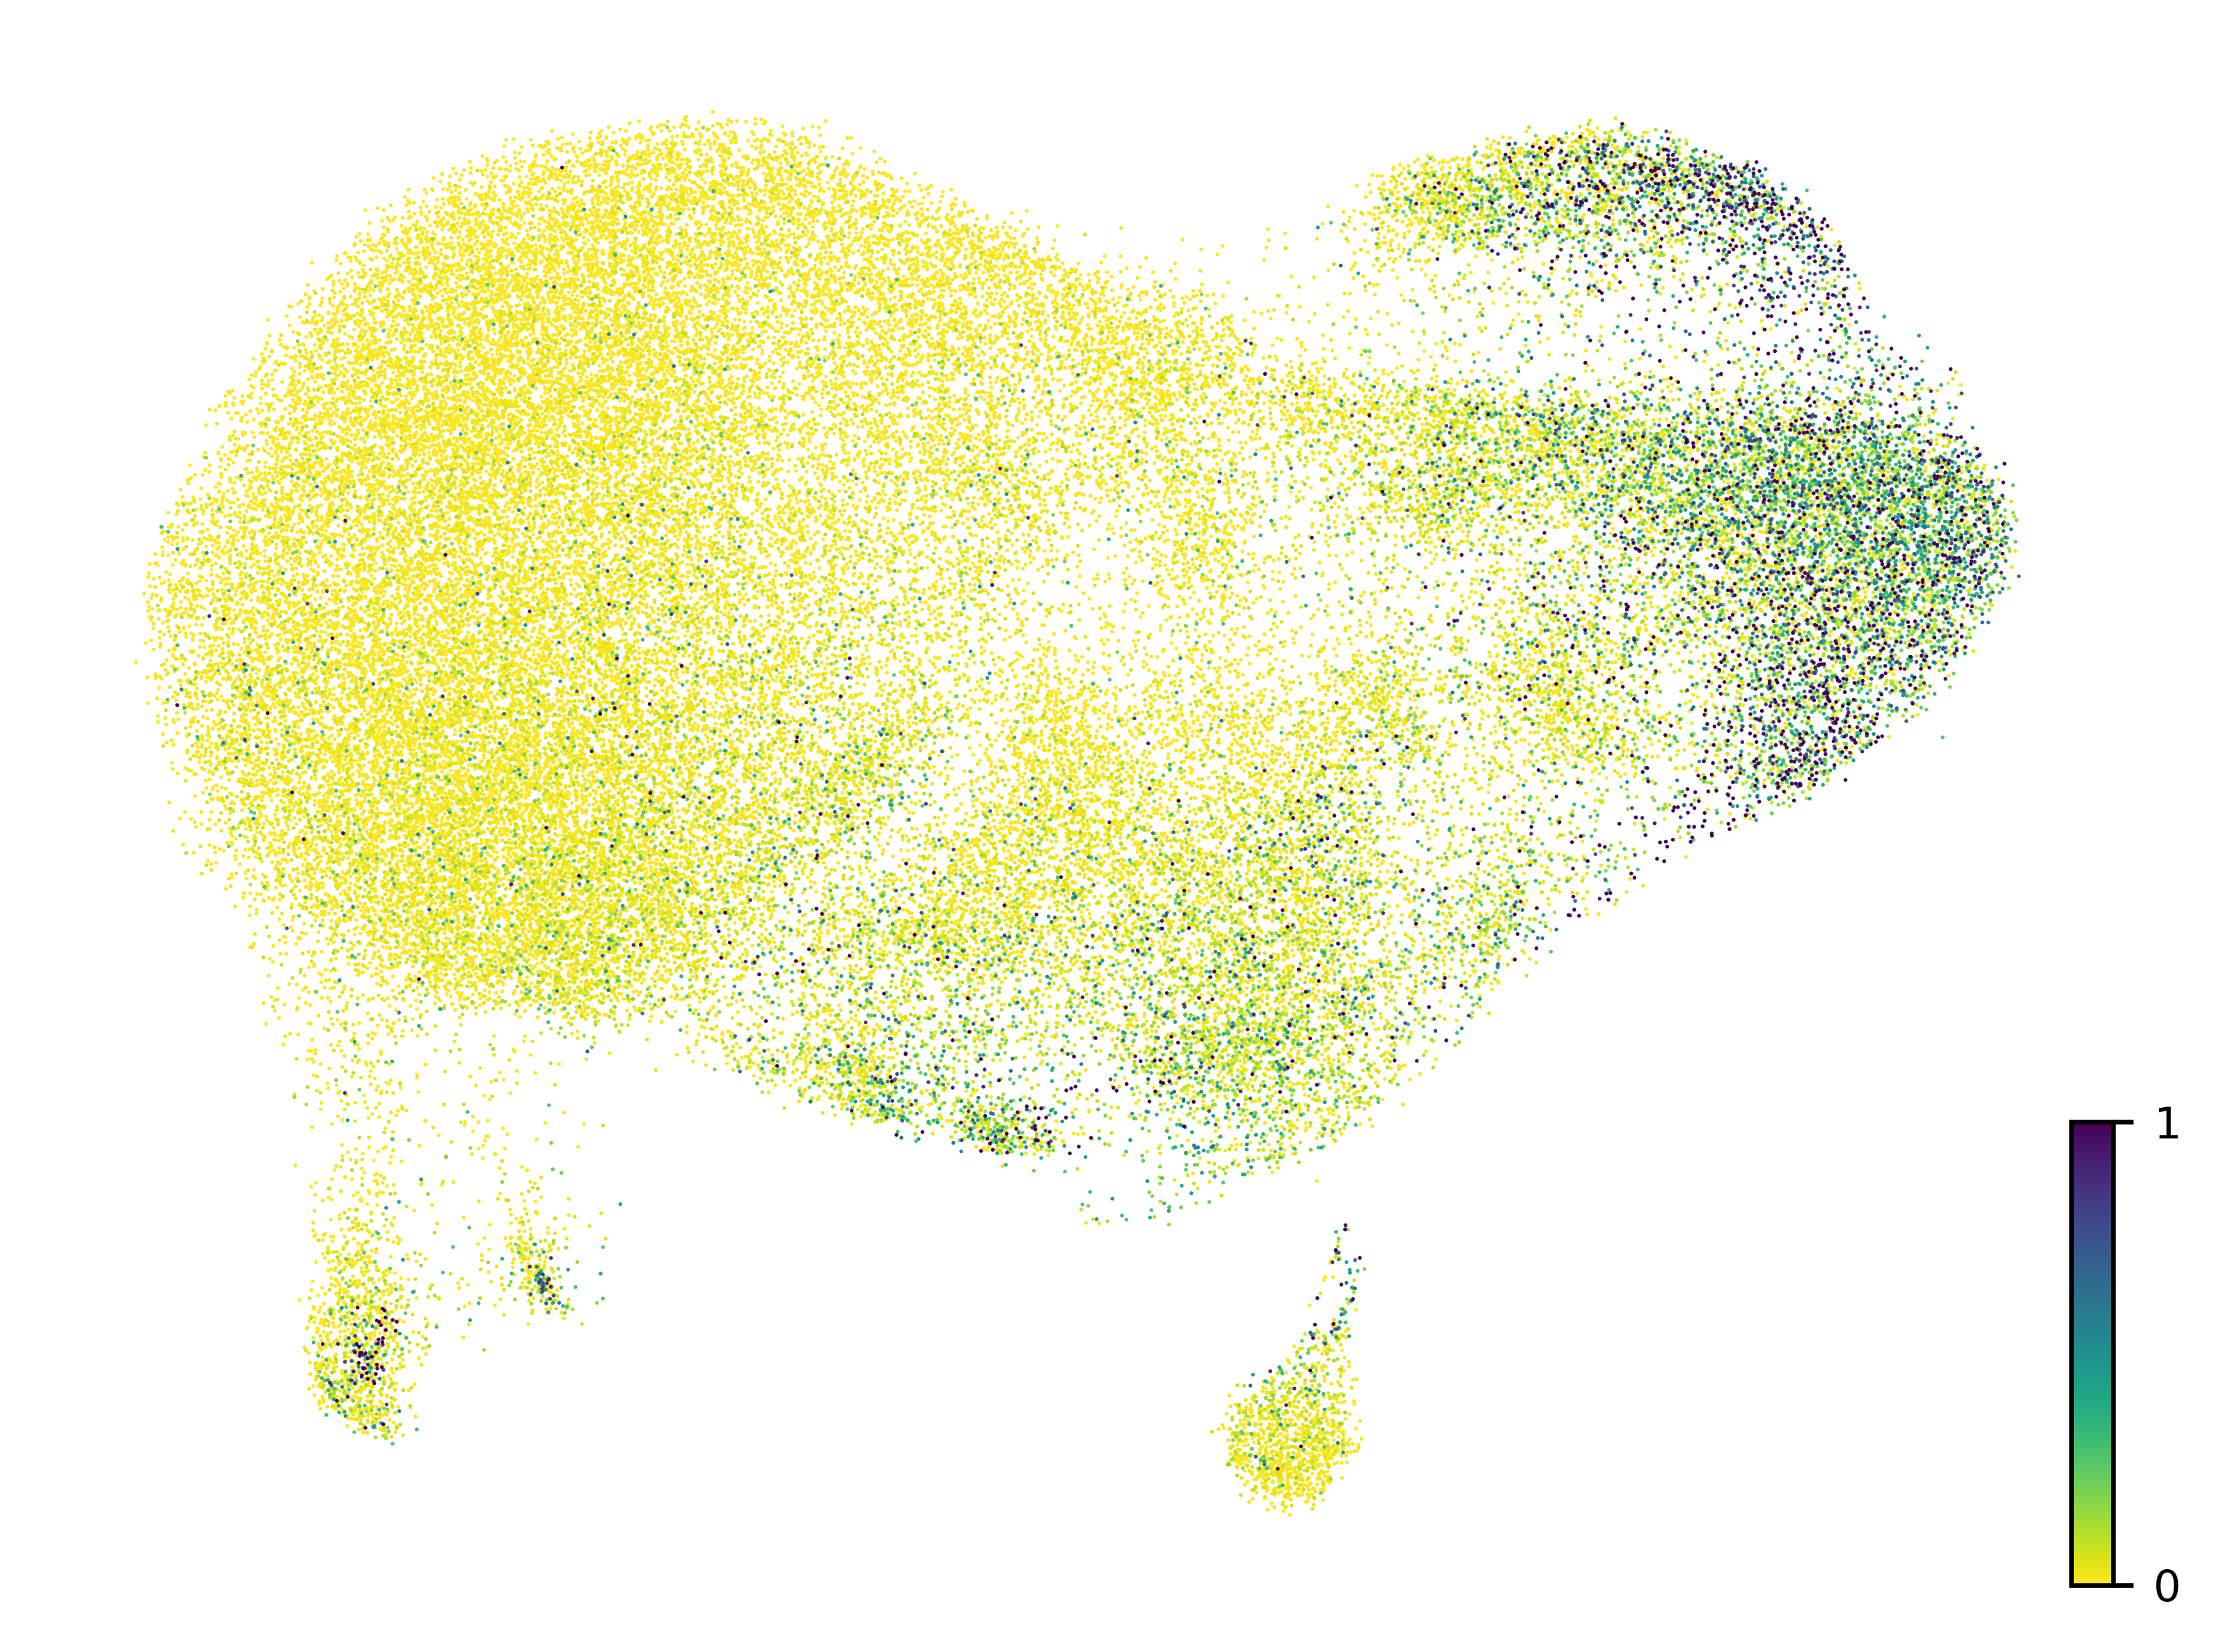

In [14]:
scv.pl.scatter(adata, basis = "umap", dpi = 600, 
                                color = "root_cells", # figsize=(25,20), save = "stream.png",
                                legend_fontsize = 12, legend_fontoutline = 2,
                                title = "",
                                fontsize = 10, linewidth = 4)

### Correct for differential kinetics in top genes

In [16]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:100]
scv.tl.differential_kinetic_test(adata, var_names=top_genes, groupby='clusters')

testing for differential kinetics
    finished (0:02:50) --> added 
    'fit_diff_kinetics', clusters displaying differential kinetics (adata.var)
    'fit_pvals_kinetics', p-values of differential kinetics (adata.var)


In [17]:
scv.tl.velocity(adata, mode = "dynamical", diff_kinetics=True)
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:01:16) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/104 cores)


  0%|          | 0/68924 [00:00<?, ?cells/s]

    finished (0:01:52) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


### Save

In [3]:
## saving:
# adata.write("./merged_scVelo_AllRegion.h5ad", compression = "gzip")

## CellRank

In [2]:
## reading back:
adata = scv.read("./trajectory_analysis/merged_scVelo_AllRegion.h5ad")

In [ ]:
scv.pl.velocity_embedding_stream(adata, color='clusters', legend_loc = 'right') 

computing velocity embedding


Compute transition matrix for combine kernel

In [ ]:
from cellrank.kernels import VelocityKernel
vk = VelocityKernel(adata, backend='threading')
vk = vk.compute_transition_matrix(n_jobs=36, backend='threading',
                                 model='stochastic', softmax_scale=None) #
vk.plot_projection(basis = "umap", recompute=True, palette=sns.color_palette("hls", 9))
scv.pl.velocity_embedding_stream(adata, vkey = "T_fwd", 
                                 color='clusters', legend_loc = 'right', dpi = 600,
                                 title = "Dynamic Velocity Stream") #figsize=[20,16],scv.settings.presenter_view = True  # set max width size for presenter view

In [ ]:
from cellrank.kernels import ConnectivityKernel
ck = ConnectivityKernel(adata)
ck = ck.compute_transition_matrix()
ck.plot_projection(basis = "umap", recompute=True, palette=sns.color_palette("hls", 9))
# scv.pl.velocity_embedding_stream(adata, vkey = "T_fwd", basis = "umap")

In [ ]:
adata.obs['Monocle_pseudotime'] = meta_data.loc[adata.obs.index, 'Monocle_pseudotime']

In [ ]:
from cellrank.kernels import PseudotimeKernel
pk = PseudotimeKernel(adata, time_key = "Monocle_pseudotime", backend='threading')
pk = pk.compute_transition_matrix(n_jobs=1, backend='threading')
pk.plot_projection(basis = "umap", recompute=True, palette=sns.color_palette("hls", 9))
# scv.pl.velocity_embedding_stream(adata, vkey = "T_fwd", basis = "umap")

Estimators

In [ ]:
combined_kernel = 0.8*vk + 0.1*ck + 0.1*pk

In [ ]:
g = cr.estimators.GPCCA(combined_kernel) ### !!! kernels
print(g)

In [ ]:
T = g.transition_matrix
T_med, T_mean, T_var = np.median(T.data), np.mean(T.data), np.var(T.data)
T_min, T_max = np.min(T.data), np.max(T.data)
print(f'med = {T_med:.6f},\nmean = {T_mean:.6f},\nvar = {T_var:.6f},\nmin = {T_min:.6f},\nmax = {T_max:.6f}')

In [ ]:
### not sure why 'T_fwd' is not in obsp. add it manually.
adata.obsp['T_fwd'] = g.transition_matrix

In [ ]:
rename = dict(zip(sorted(list(set(adata.obs['clusters']))), 
                  ['astH0','astNeu','astHR','astMet',
                'astTFP','astMic','astR0','astR1','astR2']))
new_names = [rename.get(i) for i in adata.obs['clusters']]
adata.obs['clusters'] = new_names

In [ ]:
adata.obs["cluster_ordered"] = pd.Categorical(
    values=adata.obs.clusters, 
    categories=['astH0','astNeu','astHR','astMet',
                'astTFP','astMic','astR0','astR1','astR2'], ordered=True)

In [ ]:
# scv.settings.presenter_view = False  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization

# combined_kernel.plot_projection(basis = "umap", recompute=True,color='cluster_ordered',
#                                 palette=sns.color_palette("hls", 9))
scv.pl.velocity_embedding_stream(adata, vkey = "T_fwd", 
                                 color='cluster_ordered', legend_loc = 'right', dpi = 600, #figsize=[10,8],
                                 palette=sns.color_palette("hls", 9),
                                 title = "Dynamic Velocity Stream")